## Noise Removal and Image Correction in H&E Stained Tissue Images

This script processes a high-resolution **H&E stained tissue image** to identify and remove noise using **HSV color space segmentation and K-means clustering**.  

Since the hue values of noisy regions can vary across different images, manually setting a fixed threshold may not be that effective. To address this, **K-means clustering** is applied to dynamically group pixels based on their hue values, allowing for more adaptive and accurate noise detection. The identified noise is then removed and replaced with the background color to preserve image consistency.
> Note: The noise threshold obtained by this method is for reference only.

Lower noise HSV threshold: (153, 87, 144)
Upper noise HSV threshold: (159, 220, 255)


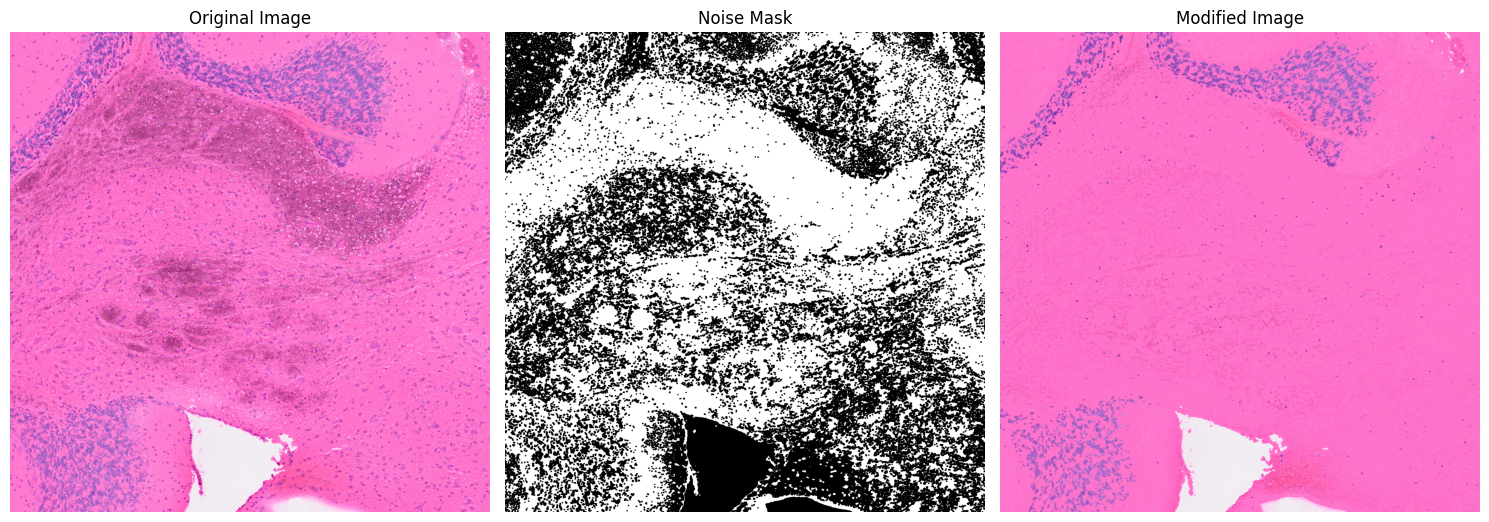

In [1]:
import cv2
import numpy as np
from skimage.io import imread
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

# Load the image and convert it to HSV color space
img_he = imread('./CytAssist_Fresh_Frozen_Sagittal_Mouse_Brain_tissue_image.tif', plugin='tifffile')
img_hsv = cv2.cvtColor(img_he, cv2.COLOR_RGB2HSV)

# Crop the image to focus on a specific region
crop_y1, crop_y2 = 17500, 22500
crop_x1, crop_x2 = 7000, 12000
crop_he = img_he[crop_y1:crop_y2, crop_x1:crop_x2]
crop_hsv = img_hsv[crop_y1:crop_y2, crop_x1:crop_x2]

# Extract individual HSV channels
h_channel = crop_hsv[:, :, 0]
s_channel = crop_hsv[:, :, 1]
v_channel = crop_hsv[:, :, 2]

# Flatten the H channel and apply K-means clustering (3 clusters)
h_flat = h_channel.flatten().reshape(-1, 1)
kmeans = KMeans(n_clusters=3, random_state=0).fit(h_flat)
labels = kmeans.labels_.reshape(h_channel.shape)

# Identify clusters based on hue intensity:
# - Blue cluster (lowest hue values)
# - Purple cluster (middle hue values)
# - Pink cluster (highest hue values)
blue_cluster = np.argmin(kmeans.cluster_centers_)
purple_cluster = np.argsort(kmeans.cluster_centers_.flatten())[1]  # Middle cluster
pink_cluster = np.argmax(kmeans.cluster_centers_)

# Select 15 pixels from the purple cluster as noise samples
purple_pixels = np.column_stack(np.where(labels == purple_cluster))
selected_indices = np.random.choice(len(purple_pixels), 8, replace=False)
selected_hsv = crop_hsv[purple_pixels[selected_indices, 0], purple_pixels[selected_indices, 1]]

# Compute HSV threshold values for noise
h_min, s_min, v_min = map(int, np.min(selected_hsv, axis=0))
h_max, s_max, v_max = map(int, np.max(selected_hsv, axis=0))

# Print the computed noise threshold values
print(f"Lower noise HSV threshold: ({h_min}, {s_min}, {v_min})")
print(f"Upper noise HSV threshold: ({h_max}, {s_max}, {v_max})")

# Create a binary mask for the noise region
noise_mask = cv2.inRange(crop_hsv, (h_min, s_min, v_min), (h_max, s_max, v_max))

# Apply morphological closing to remove small noise artifacts
kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (15, 15))
cleaned_noise_mask = cv2.morphologyEx(noise_mask, cv2.MORPH_CLOSE, kernel)

# Invert the mask to preserve non-noise areas
cleaned_mask = cv2.bitwise_not(cleaned_noise_mask)

# Replace noise pixels with the background color (median pink hue)
pink_cluster = np.argmax(kmeans.cluster_centers_)
pink_color = np.median(crop_hsv[labels == pink_cluster], axis=0).astype(np.uint8)

# Apply the replacement to the noise region
replacement_hsv = crop_hsv.copy()
replacement_hsv[cleaned_noise_mask > 0] = pink_color

# Update the modified region in the original HSV image
modified_hsv = img_hsv.copy()
modified_hsv[crop_y1:crop_y2, crop_x1:crop_x2] = replacement_hsv

# Convert the modified crop back to RGB for visualization
modified_crop_rgb = cv2.cvtColor(replacement_hsv, cv2.COLOR_HSV2RGB)

# Display results: original image, noise mask, and modified image
plt.figure(figsize=(15, 10))

plt.subplot(1, 3, 1)
plt.imshow(crop_he)
plt.title("Original Image")
plt.axis('off')

plt.subplot(1, 3, 2)
plt.imshow(cleaned_noise_mask, cmap='gray')
plt.title("Noise Mask")
plt.axis('off')

plt.subplot(1, 3, 3)
plt.imshow(modified_crop_rgb)
plt.title("Modified Image")
plt.axis('off')

plt.tight_layout()
plt.show()
